# Cardiovascular Disease Prediction

This notebook explores an analysis of attributes that are potential risk factors for coronary heart disease (CHD). It also fits a logistic regression model for predicting the 10-year risk of CHD.

We look at various demographic, behavioral, and medical risk factors along with lab values and vital signs to uncover patterns, insights, and 10 year risk of CHD

## Executive Summary

This analysis applied logistic regression to predict 10-year coronary heart disease (CHD) risk using the Framingham dataset. At the default threshold (0.5), the model achieved high overall accuracy (86%) but failed to identify most true CHD cases (recall only 0.09). Adjusting the threshold to 0.18 significantly improved recall (0.60) for at-risk individuals, though at the cost of reduced precision (0.30) and lower overall accuracy (73%).

Key predictors of CHD risk include age, systolic blood pressure, smoking, glucose, and blood pressure medication use. Female sex and higher education were protective. These findings align with established cardiovascular risk factors, suggesting the model is clinically meaningful but must be carefully calibrated for deployment.

## Dataset Overview


The dataset is publically available on  Kaggle, and includes data from an ongoing cardiovascular study on residents of Framingham, Massachusetts. The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD). The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

**Data Description**

Demographic
*   sex: male or female("M" or "F"; binary: 1 = "M", 0 = "F")
*   age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)
*   education: 1-4; 1: Less than Grade 12 2: Grade 12 or GED. 3: Some college or technical school. 4: College or technical school graduate or higher

Behavioral
*   isSmoking: whether or not the patient is a current smoker ("YES" or "NO")
*   cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical (history)
*   bpMeds: whether or not the patient was on blood pressure medication (Nominal)
* prevalentStroke: whether or not the patient had previously had a stroke
(Nominal)
* prevalentHyp: whether or not the patient was hypertensive (Nominal)
* diabetes: whether or not the patient had diabetes (Nominal)

Lab Values and Vital Signs (current)
* totChol: total cholesterol level (Continuous)
* sysBP: systolic blood pressure (Continuous)
* diaBP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
* glucose: glucose level (Continuous)

Predict variable (desired target)
* tenYearCHD: 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”

## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import sklearn as sk
import functions as fn
import kagglehub as kh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("dark", 14)
pd.set_option('display.max_columns', None)

# Download latest version
path = kh.dataset_download("christofel04/cardiovascular-study-dataset-predict-heart-disea")

print("Path to dataset files:", path)

Path to dataset files: /Users/murtaza.aziz/.cache/kagglehub/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea/versions/1


## Data Loading, Sanity Check, and Cleaning

In [5]:
import os

# Construct the full path to the training CSV file within the downloaded directory
train_file_path = os.path.join(path, 'train.csv')
test_file_path = os.path.join(path, 'test.csv')

train = fn.load_csv(train_file_path)
test = fn.load_csv(test_file_path)
display(train.head())
display(test.head())

Loaded /Users/murtaza.aziz/.cache/kagglehub/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea/versions/1/train.csv successfully.
Loaded /Users/murtaza.aziz/.cache/kagglehub/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea/versions/1/test.csv successfully.


,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,3390,43,2.0,M,YES,35.0,0.0,0,0,0,207.0,117.0,65.0,24.42,60.0,100.0
1,3391,56,3.0,F,NO,0.0,0.0,0,0,0,192.0,122.0,82.5,28.61,68.0,58.0
2,3392,58,1.0,F,YES,20.0,0.0,0,1,0,260.0,180.0,100.0,25.56,100.0,NaN
3,3393,47,3.0,F,NO,0.0,0.0,0,0,0,231.0,102.5,66.0,23.40,70.0,78.0
4,3394,44,1.0,M,NO,0.0,0.0,0,0,0,160.0,118.5,87.0,25.81,54.0,NaN


In [6]:
# Sanity Check and Cleaning
train = fn.sanity_check(train)
train = fn.clean_data(train)
test = fn.sanity_check(test)
test = fn.clean_data(test)

display(train.head())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

,id,sexBinary,age,education,isSmoking,cigsPerDay,bpMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,tenYearCHD
0,0,1,64,2.0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,0,36,4.0,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,1,46,1.0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,0,50,1.0,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,1,64,1.0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


,id,sexBinary,age,education,isSmoking,cigsPerDay,bpMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,3390,0,43,2.0,1,35.0,0.0,0,0,0,207.0,117.0,65.0,24.42,60.0,100.0
1,3391,1,56,3.0,0,0.0,0.0,0,0,0,192.0,122.0,82.5,28.61,68.0,58.0
2,3392,1,58,1.0,1,20.0,0.0,0,1,0,260.0,180.0,100.0,25.56,100.0,NaN
3,3393,1,47,3.0,0,0.0,0.0,0,0,0,231.0,102.5,66.0,23.40,70.0,78.0
4,3394,0,44,1.0,0,0.0,0.0,0,0,0,160.0,118.5,87.0,25.81,54.0,NaN


## Exploratory Data Analysis

### Training Data Descriptive Statistics

In [7]:
train.describe()

,id,sexBinary,age,education,isSmoking,cigsPerDay,bpMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,tenYearCHD
count,3390.000000,3390.000000,3390.000000,3303.000000,3390.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,0.567257,49.542183,1.970936,0.497640,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,0.495529,8.592878,1.019081,0.500068,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,1.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


### Numerical and Categorical Features

In [8]:
numerical_features = train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = train.select_dtypes(include=['object','category']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['id', 'sexBinary', 'age', 'education', 'isSmoking', 'cigsPerDay', 'bpMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'tenYearCHD']
Categorical Features: []


### Demographic Distributions

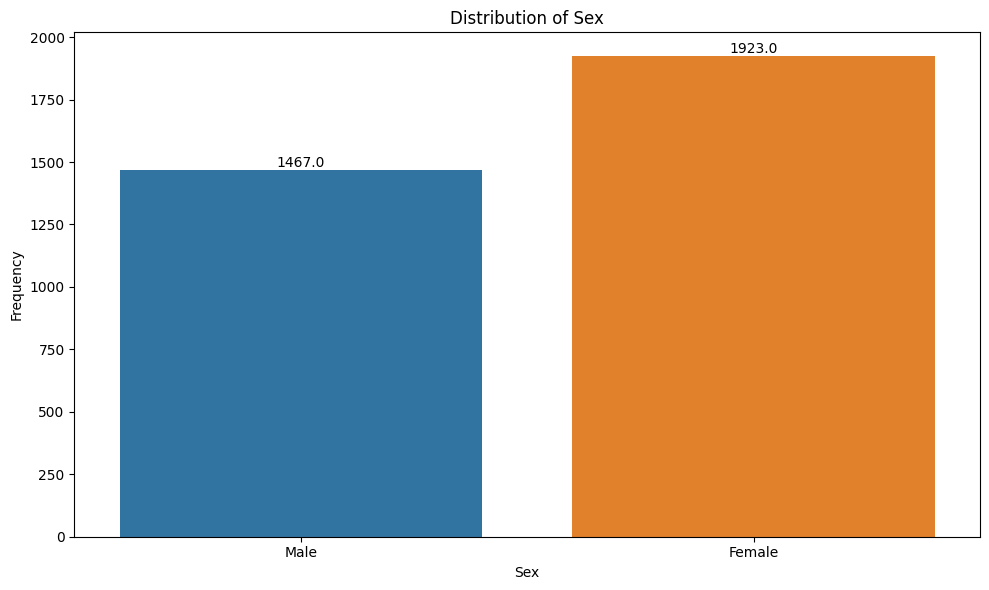

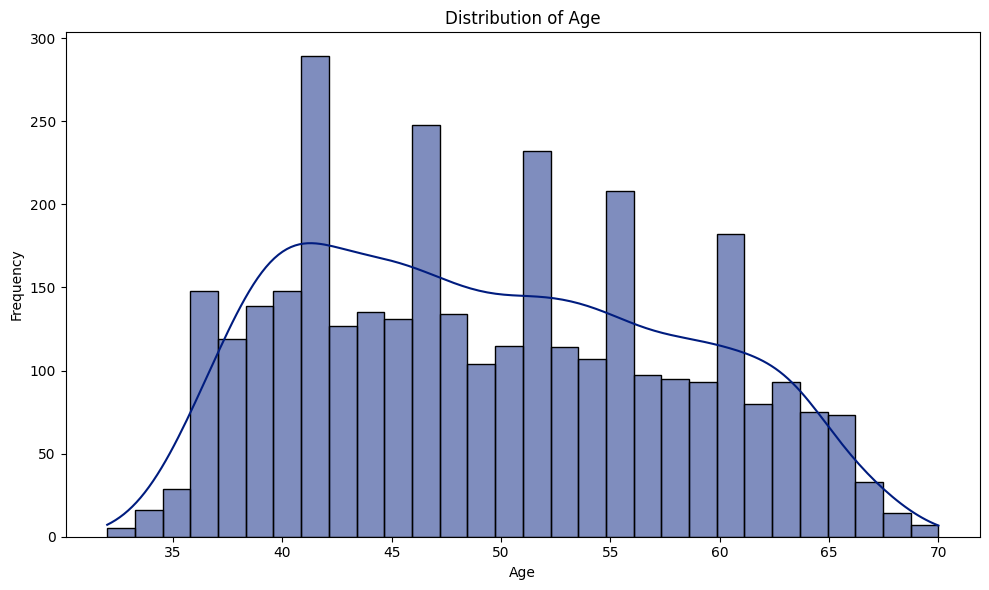

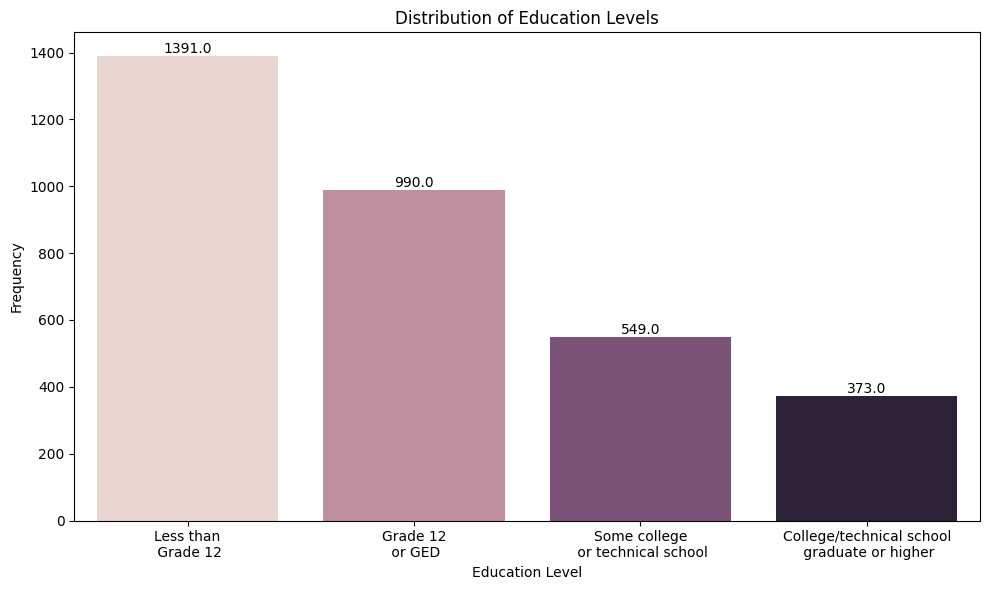

In [9]:
#Distribution of Sex
plt.figure(figsize=(10, 6))
sns.countplot(x='sexBinary', data=train, hue='sexBinary', dodge=False, legend=False)
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Male', 'Female'])
#Add counts for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

#Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(train['age'], bins=30, kde=True, color= palette[0])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#Distribution of Education Levels
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data= train, hue='education', dodge=False, legend=False)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3], ['Less than\n Grade 12', 'Grade 12\n or GED', 'Some college\n or technical school', 'College/technical school\n graduate or higher']) #Wrap xticks
#Add counts for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()



### Lab Values and Vital Signs Distributions

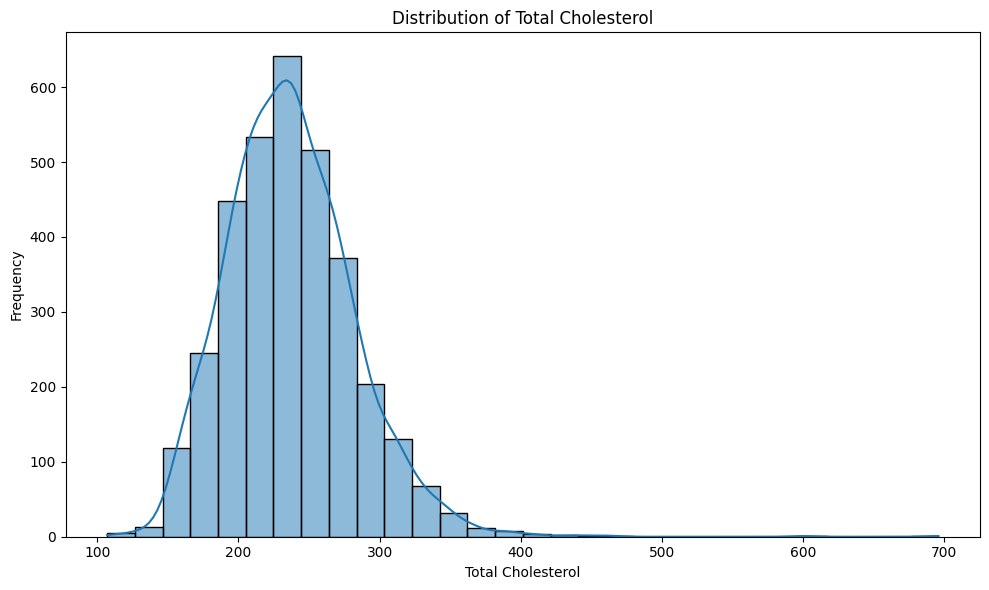

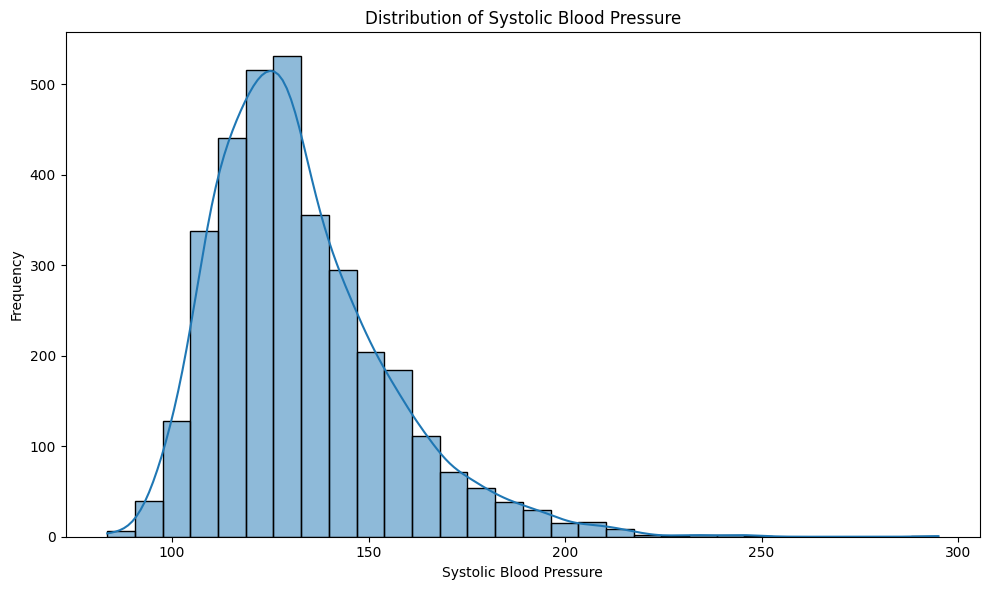

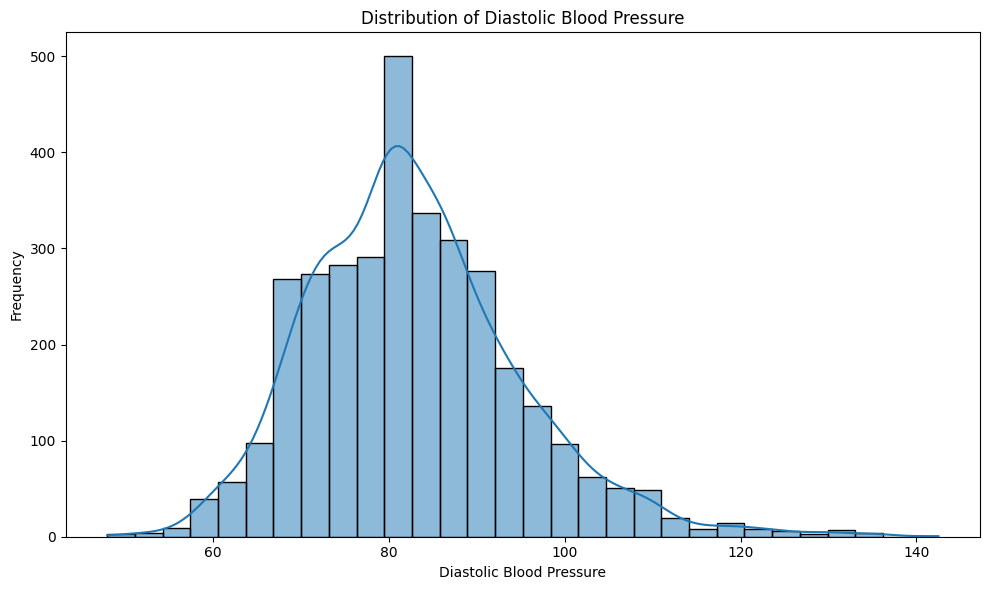

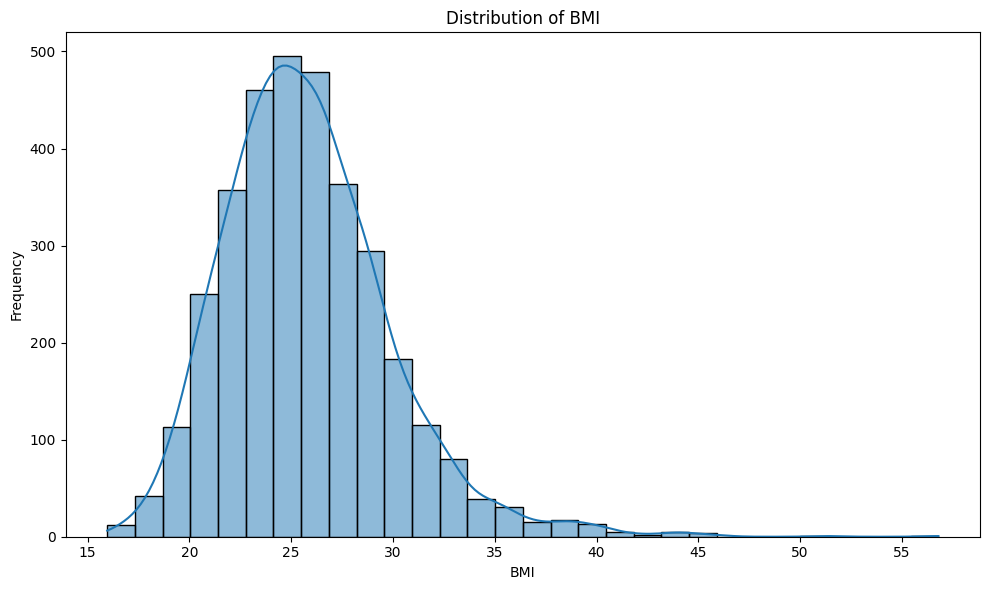

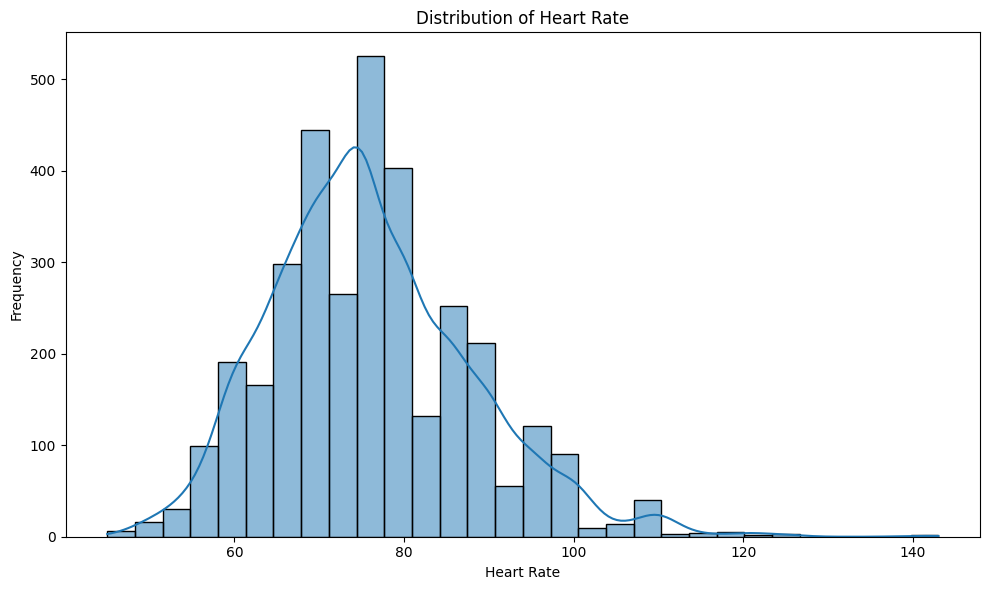

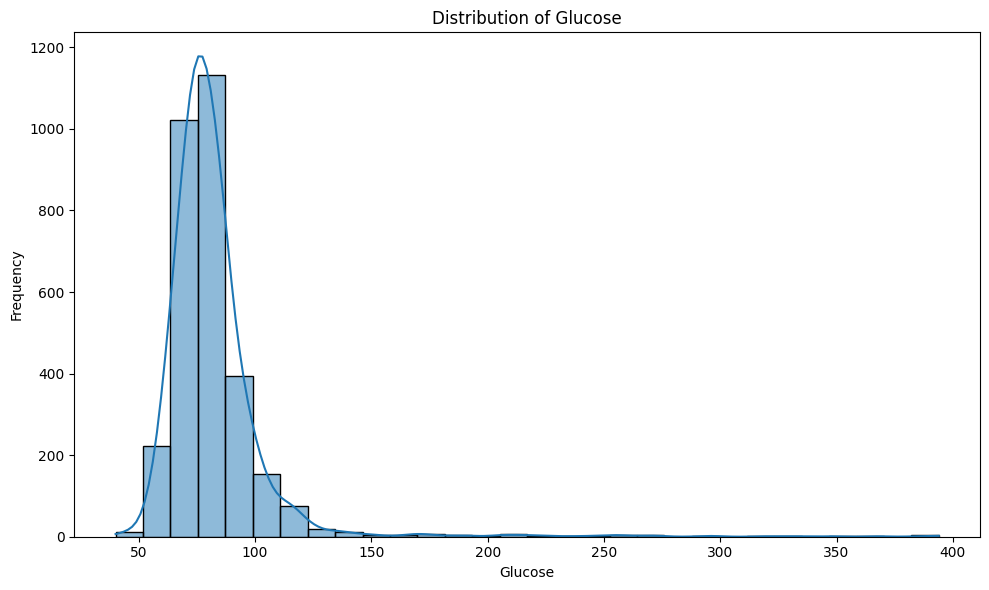

In [10]:
# Distribution of Total Cholesterol
plt.figure(figsize=(10, 6))
sns.histplot(train['totChol'].dropna(), bins=30, kde=True)
plt.title('Distribution of Total Cholesterol')
plt.xlabel('Total Cholesterol')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of Systolic Blood Pressure
plt.figure(figsize=(10, 6))
sns.histplot(train['sysBP'].dropna(), bins=30, kde=True)
plt.title('Distribution of Systolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of Diastolic Blood Pressure
plt.figure(figsize=(10, 6))
sns.histplot(train['diaBP'].dropna(), bins=30, kde=True)
plt.title('Distribution of Diastolic Blood Pressure')
plt.xlabel('Diastolic Blood Pressure')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of BMI
plt.figure(figsize=(10, 6))
sns.histplot(train['BMI'].dropna(), bins=30, kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of Heart Rate
plt.figure(figsize=(10, 6))
sns.histplot(train['heartRate'].dropna(), bins=30, kde=True)
plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of Glucose
plt.figure(figsize=(10, 6))
sns.histplot(train['glucose'].dropna(), bins=30, kde=True)
plt.title('Distribution of Glucose')
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Target Variable Distribution

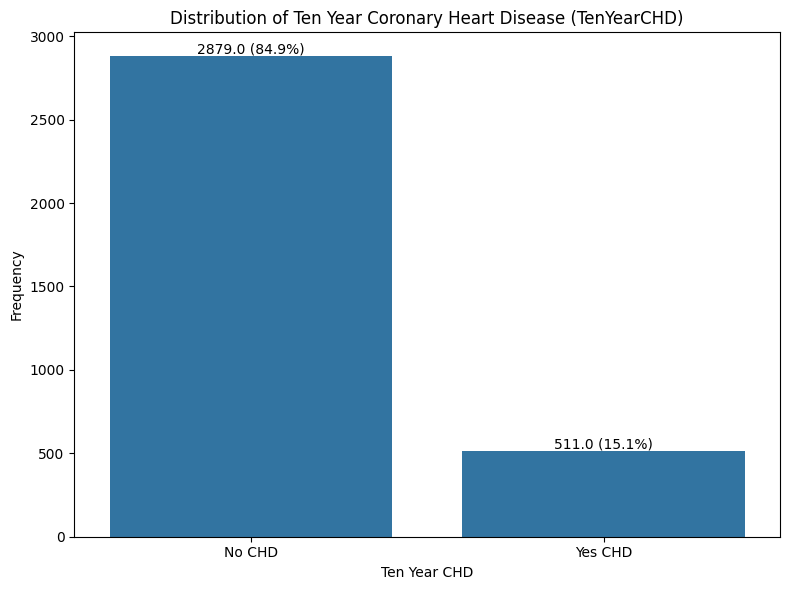

In [11]:
# Distribution of the target variable (TenYearCHD)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='tenYearCHD', data=train)
plt.title('Distribution of Ten Year Coronary Heart Disease (TenYearCHD)')
plt.xlabel('Ten Year CHD')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No CHD', 'Yes CHD'])

# Calculate the total number of rows for percentage calculation
total = len(train)

# Annotate the count and percentage of each class on the countplot
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{height} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Medical History Risk Factor Distributions

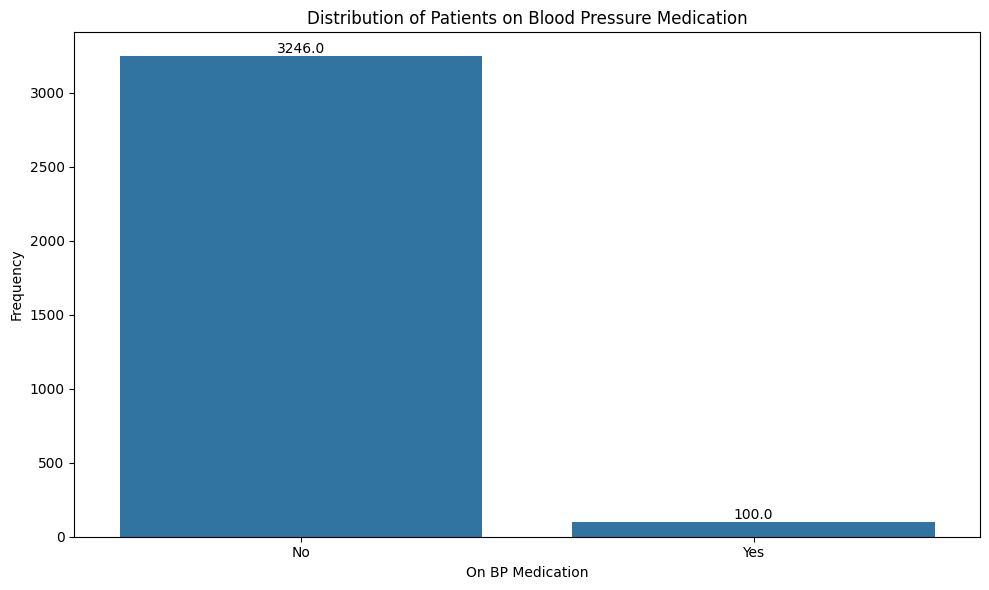

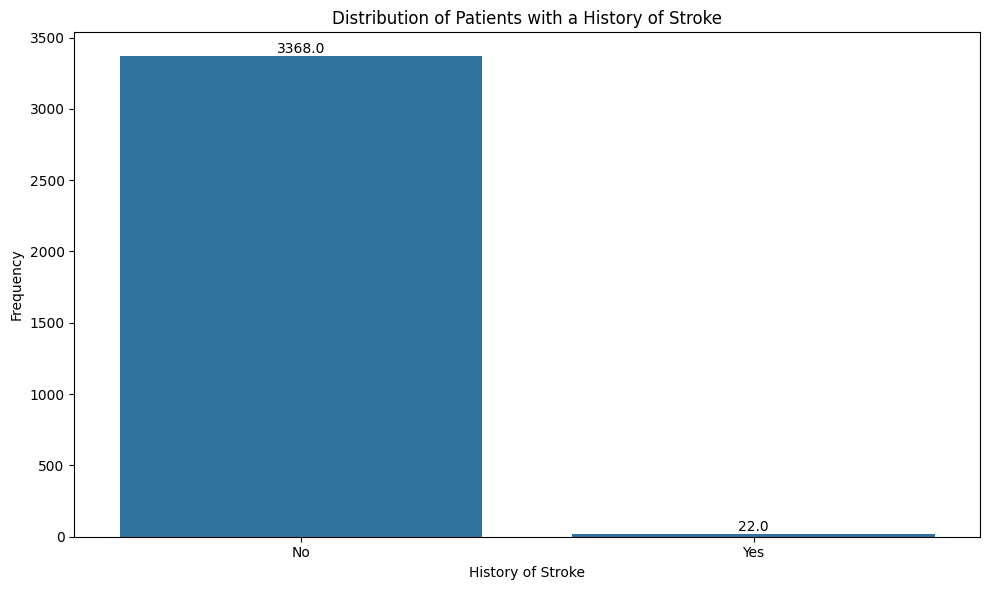

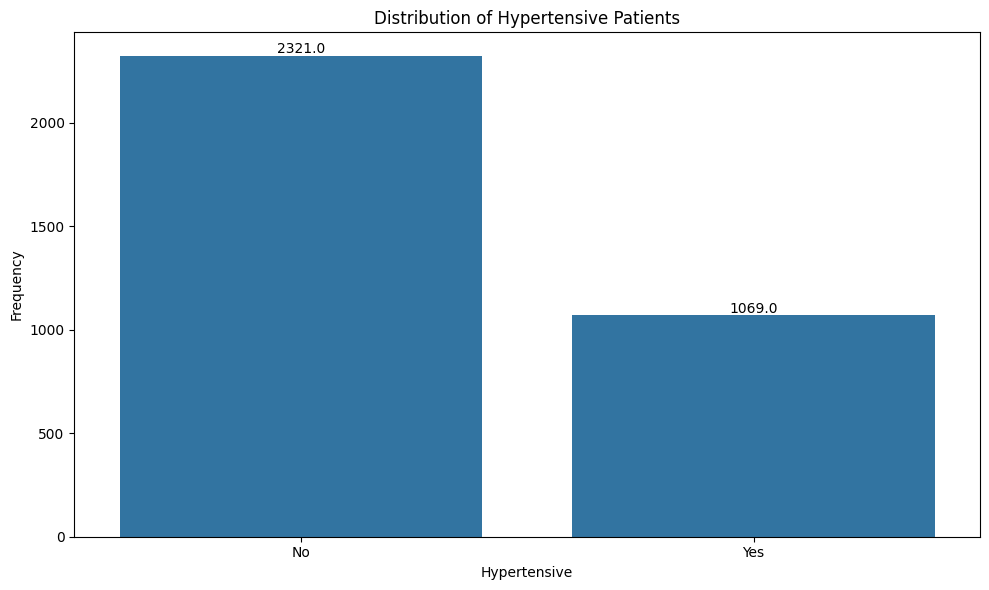

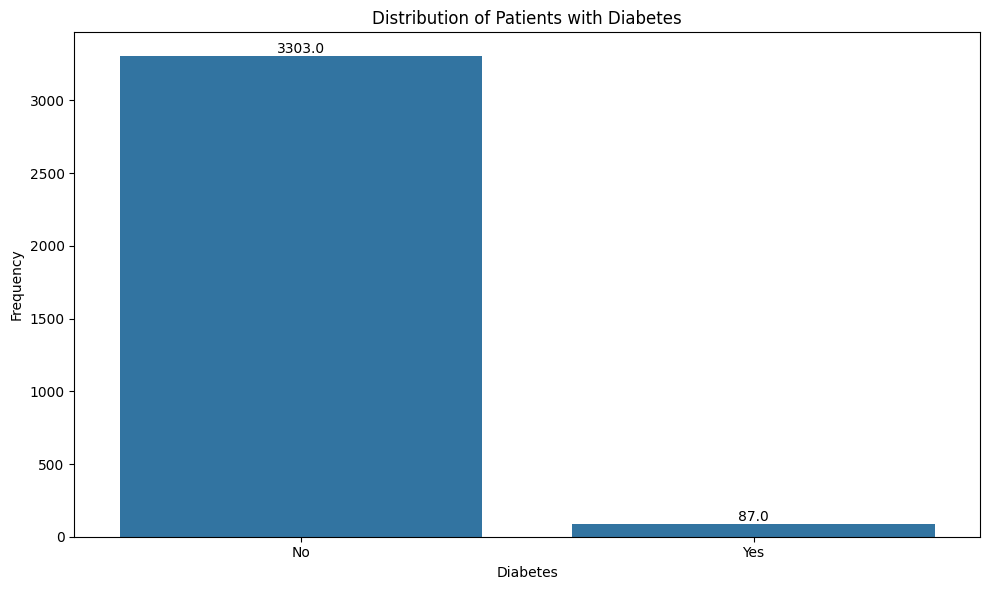

In [12]:
# Distribution of patients on blood pressure medication
plt.figure(figsize=(10, 6))
sns.countplot(x='bpMeds', data=train)
plt.title('Distribution of Patients on Blood Pressure Medication')
plt.xlabel('On BP Medication')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No', 'Yes'])
#Add count for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

# Distribution of patients with a history of stroke
plt.figure(figsize=(10, 6))
sns.countplot(x='prevalentStroke', data=train)
plt.title('Distribution of Patients with a History of Stroke')
plt.xlabel('History of Stroke')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No', 'Yes'])
#Add count for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

# Distribution of hypertensive patients
plt.figure(figsize=(10, 6))
sns.countplot(x='prevalentHyp', data=train)
plt.title('Distribution of Hypertensive Patients')
plt.xlabel('Hypertensive')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No', 'Yes'])
#Add count for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

# Distribution of patients with diabetes
plt.figure(figsize=(10, 6))
sns.countplot(x='diabetes', data=train)
plt.title('Distribution of Patients with Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No', 'Yes'])
#Add count for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

### Behavioral Risk Factor Distributions

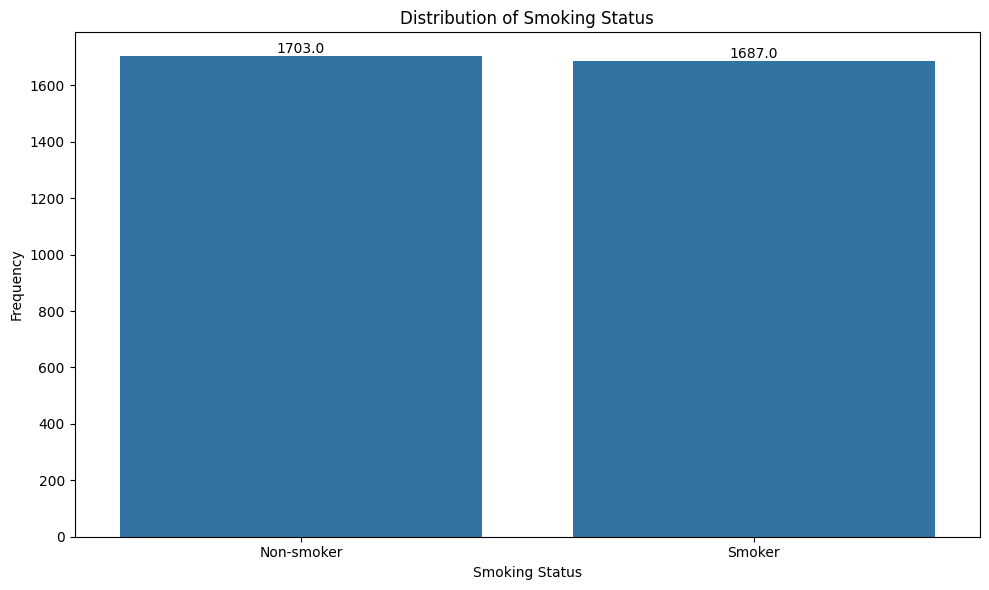

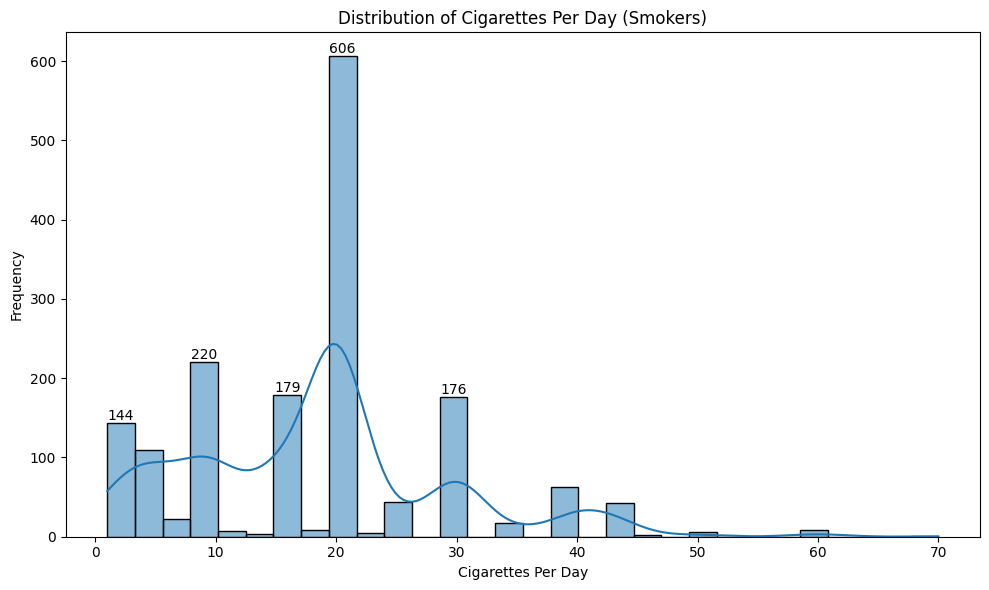

In [13]:
# Distribution of Smoking Status
plt.figure(figsize=(10, 6))
sns.countplot(x='isSmoking', data=train)
plt.title('Distribution of Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-smoker', 'Smoker'])
#Add count for each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
plt.tight_layout()
plt.show()

# Distribution of Cigs Per Day (for smokers)
plt.figure(figsize=(10, 6))
ax = sns.histplot(train[train['isSmoking'] == 1]['cigsPerDay'].dropna(), bins=30, kde=True)
plt.title('Distribution of Cigarettes Per Day (Smokers)')
plt.xlabel('Cigarettes Per Day')
plt.ylabel('Frequency')

# Get patches and sort by height
patches = ax.patches
patches = sorted(patches, key=lambda x: x.get_height(), reverse=True)

#Add count for 5 tallest bars
for i, p in enumerate(patches[:5]):
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

##Correlation Matrix

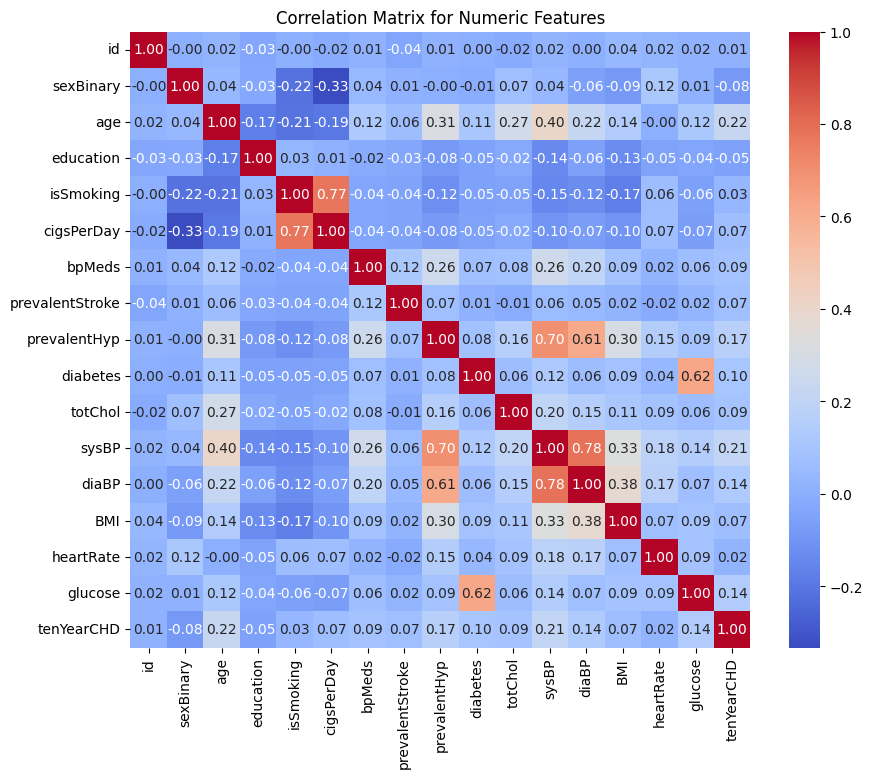

In [14]:
#Correlation Matrix for numeric features
corr_matrix = train[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numeric Features")
plt.show()

##Build Full Scikit-Learn Pipeline

In [15]:
# Modifying Training and Testing Data
X_train = train.drop(columns=["tenYearCHD","id"])
y_train = train["tenYearCHD"]

X_test = test.drop(columns=["id"])

# Feature groups
categorical_features = ["sexBinary", "education", "bpMeds", "isSmoking"]
median_features = ["glucose"]
numeric_features = [col for col in X_train.columns
                    if col not in categorical_features and col not in median_features]
# Transformers
numeric_transformer_mean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

numeric_transformer_median = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_mean", numeric_transformer_mean, numeric_features),
        ("num_median", numeric_transformer_median, median_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Full pipeline with logistic regression
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Fit on training data
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))

# Predict on test data
test_preds = model.predict(X_test)  # 0/1 predictions
test_probs = model.predict_proba(X_test)[:, 1]  # probability of CHD

# Create submission DataFrame
submission = pd.DataFrame({
    "id": test["id"],
    "CHD_Prediction": test_preds,
    "CHD_Probability": test_probs
})

submission.head(10)




Train Accuracy: 0.8589970501474926


,id,CHD_Prediction,CHD_Probability
0,3390,0,0.153373
1,3391,0,0.068572
2,3392,0,0.354037
3,3393,0,0.043681
4,3394,0,0.058035
5,3395,0,0.036736
6,3396,0,0.143553
7,3397,0,0.069806
8,3398,0,0.060584
9,3399,0,0.026406


In [16]:
# Get the count of each prediction value in the submission DataFrame
prediction_counts = submission['CHD_Prediction'].value_counts()

print("Count of CHD_Prediction:")
print(prediction_counts)

Count of CHD_Prediction:
CHD_Prediction
0    834
1     14
Name: count, dtype: int64


### Interpret Coefficients

In [17]:
# Get feature names from preprocessing
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Extract coefficients from logistic regression
coefs = model.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "OddsRatio": np.exp(coefs),
    "LogOdds": coefs  # same as coefficient
}).sort_values(by="LogOdds", ascending=False)

print("\nTop Predictors by Odds Ratio:")
print(coef_df.head(9))

print("\nLowest Predictors by Odds Ratio:")
print(coef_df.tail(9))


Top Predictors by Odds Ratio:
                      Feature  Coefficient  OddsRatio   LogOdds
0               num_mean__age     0.524437   1.689508  0.524437
6             num_mean__sysBP     0.352145   1.422115  0.352145
1        num_mean__cigsPerDay     0.250355   1.284481  0.250355
10        num_median__glucose     0.202480   1.224436  0.202480
16            cat__bpMeds_1.0     0.178902   1.195904  0.178902
17         cat__isSmoking_1.0     0.140184   1.150485  0.140184
5           num_mean__totChol     0.118621   1.125943  0.118621
2   num_mean__prevalentStroke     0.094842   1.099485  0.094842
3      num_mean__prevalentHyp     0.089341   1.093453  0.089341

Lowest Predictors by Odds Ratio:
                Feature  Coefficient  OddsRatio   LogOdds
15   cat__education_4.0     0.063365   1.065415  0.063365
12   cat__education_1.0     0.038812   1.039575  0.038812
4    num_mean__diabetes     0.006591   1.006612  0.006591
8         num_mean__BMI    -0.000109   0.999891 -0.000109
14   

### Plot Odds-Ratio

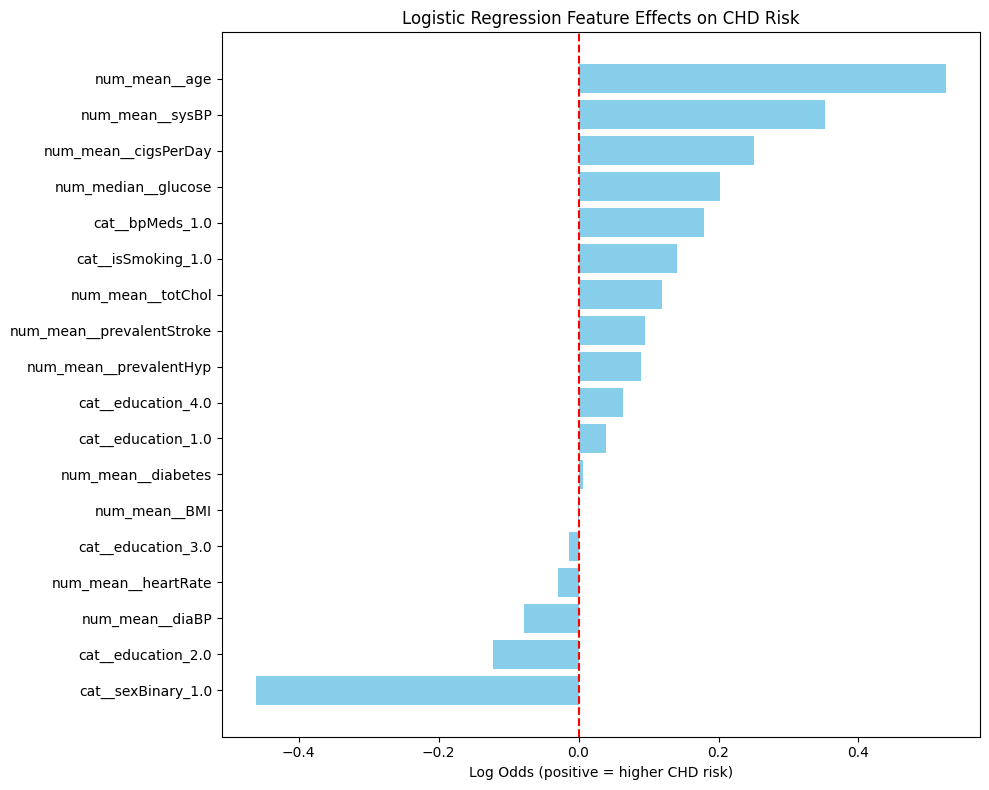

In [18]:
plt.figure(figsize=(10, 8))
coef_df_sorted = coef_df.sort_values(by="LogOdds", ascending=True)

plt.barh(coef_df_sorted["Feature"], coef_df_sorted["LogOdds"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Log Odds (positive = higher CHD risk)")
plt.title("Logistic Regression Feature Effects on CHD Risk")
plt.tight_layout()
plt.show()

### Odd-ratio Plot

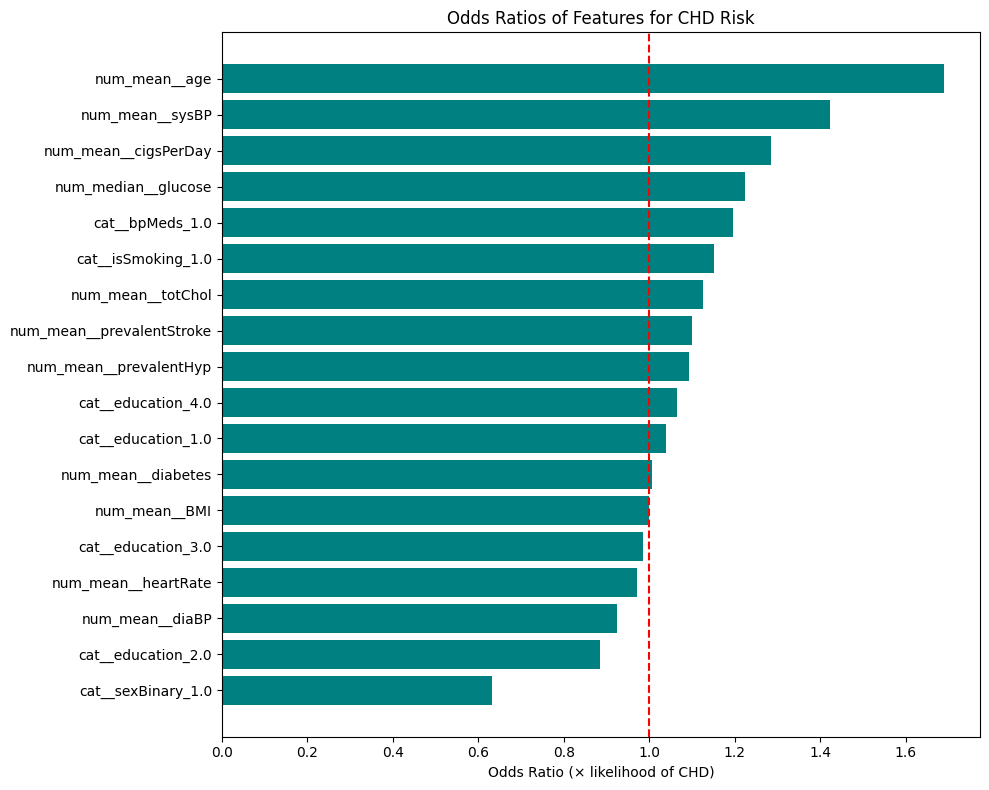

In [19]:
plt.figure(figsize=(10, 8))
coef_df_sorted = coef_df.sort_values(by="OddsRatio", ascending=True)

plt.barh(coef_df_sorted["Feature"], coef_df_sorted["OddsRatio"], color="teal")
plt.axvline(1, color="red", linestyle="--")
plt.xlabel("Odds Ratio (× likelihood of CHD)")
plt.title("Odds Ratios of Features for CHD Risk")
plt.tight_layout()
plt.show()

### Top 5 Strongest Risk Factors

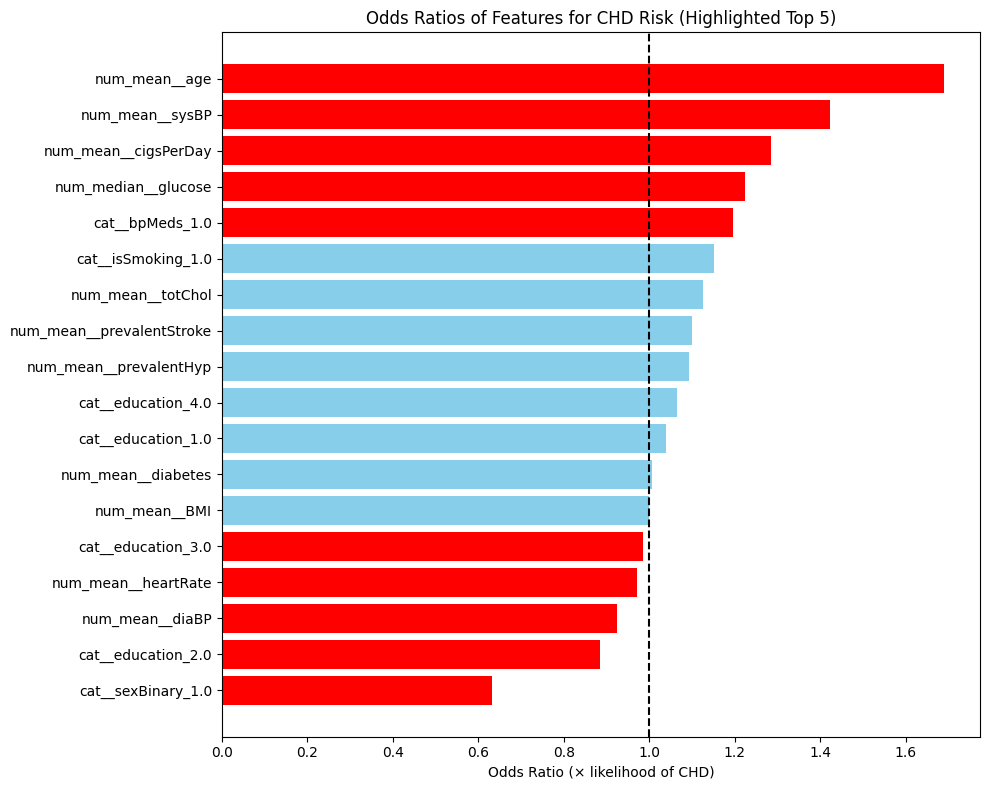

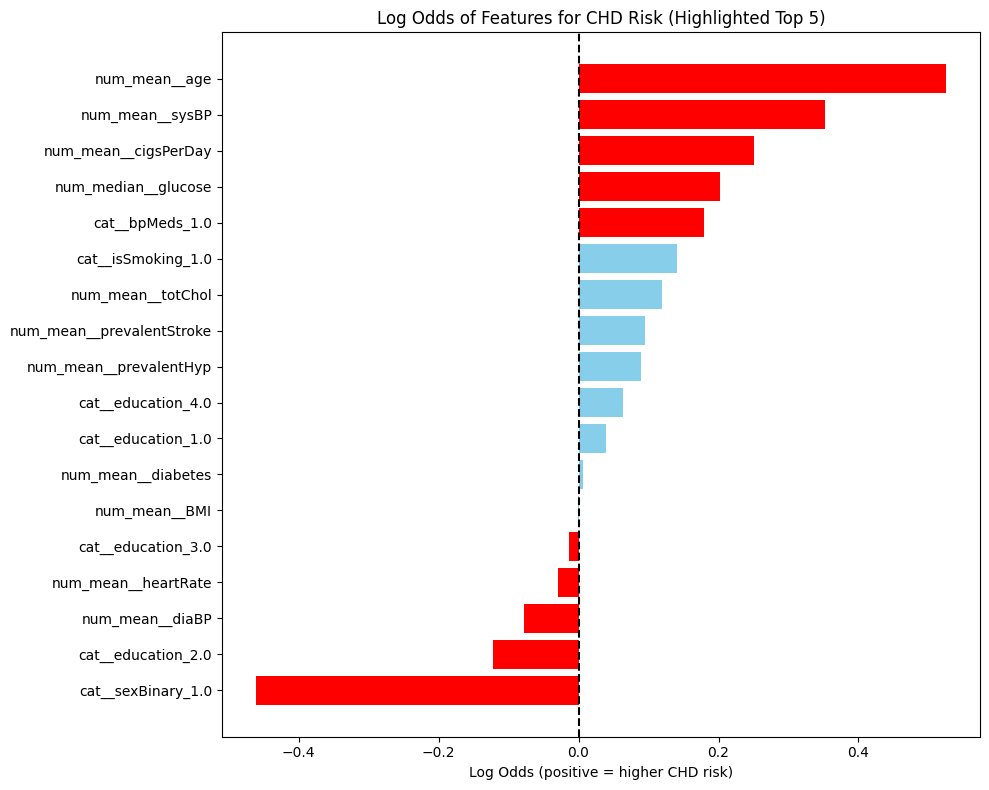

🔺 Top 5 Risk-Increasing Features:
                 Feature  OddsRatio
0          num_mean__age   1.689508
6        num_mean__sysBP   1.422115
1   num_mean__cigsPerDay   1.284481
10   num_median__glucose   1.224436
16       cat__bpMeds_1.0   1.195904

🔻 Top 5 Protective Features:
                Feature  OddsRatio
11   cat__sexBinary_1.0   0.630965
13   cat__education_2.0   0.884621
7       num_mean__diaBP   0.924839
9   num_mean__heartRate   0.970591
14   cat__education_3.0   0.985963


In [20]:
# --- Highlight top 5 risk-increasing and top 5 protective features ---
top_positive = coef_df.sort_values("OddsRatio", ascending=False).head(5)
top_negative = coef_df.sort_values("OddsRatio", ascending=True).head(5)
highlight = pd.concat([top_positive, top_negative])

# --- Plot Odds Ratios with highlights ---
plt.figure(figsize=(10, 8))
coef_df_sorted = coef_df.sort_values(by="OddsRatio", ascending=True)

colors = ["red" if f in highlight["Feature"].values else "skyblue"
          for f in coef_df_sorted["Feature"]]

plt.barh(coef_df_sorted["Feature"], coef_df_sorted["OddsRatio"], color=colors)
plt.axvline(1, color="black", linestyle="--")
plt.xlabel("Odds Ratio (× likelihood of CHD)")
plt.title("Odds Ratios of Features for CHD Risk (Highlighted Top 5)")
plt.tight_layout()
plt.show()

# --- Plot Log Odds with highlights ---
plt.figure(figsize=(10, 8))
coef_df_sorted = coef_df.sort_values(by="LogOdds", ascending=True)

colors = ["red" if f in highlight["Feature"].values else "skyblue"
          for f in coef_df_sorted["Feature"]]

plt.barh(coef_df_sorted["Feature"], coef_df_sorted["LogOdds"], color=colors)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Log Odds (positive = higher CHD risk)")
plt.title("Log Odds of Features for CHD Risk (Highlighted Top 5)")
plt.tight_layout()
plt.show()

print("🔺 Top 5 Risk-Increasing Features:")
print(top_positive[["Feature", "OddsRatio"]])
print("\n🔻 Top 5 Protective Features:")
print(top_negative[["Feature", "OddsRatio"]])

In [21]:
def interpret_odds_ratio(feature, odds_ratio):
    if odds_ratio > 1:
        return f"{feature} increases CHD risk by about {odds_ratio:.2f}×"
    else:
        return f"{feature} decreases CHD risk to about {odds_ratio:.2f}× (protective)"

print("\n🔺 Top 5 Risk-Increasing Factors:")
for _, row in top_positive.iterrows():
    print("-", interpret_odds_ratio(row["Feature"], row["OddsRatio"]))

print("\n🔻 Top 5 Protective Factors:")
for _, row in top_negative.iterrows():
    print("-", interpret_odds_ratio(row["Feature"], row["OddsRatio"]))


🔺 Top 5 Risk-Increasing Factors:
- num_mean__age increases CHD risk by about 1.69×
- num_mean__sysBP increases CHD risk by about 1.42×
- num_mean__cigsPerDay increases CHD risk by about 1.28×
- num_median__glucose increases CHD risk by about 1.22×
- cat__bpMeds_1.0 increases CHD risk by about 1.20×

🔻 Top 5 Protective Factors:
- cat__sexBinary_1.0 decreases CHD risk to about 0.63× (protective)
- cat__education_2.0 decreases CHD risk to about 0.88× (protective)
- num_mean__diaBP decreases CHD risk to about 0.92× (protective)
- num_mean__heartRate decreases CHD risk to about 0.97× (protective)
- cat__education_3.0 decreases CHD risk to about 0.99× (protective)


## Choosing the Threshold

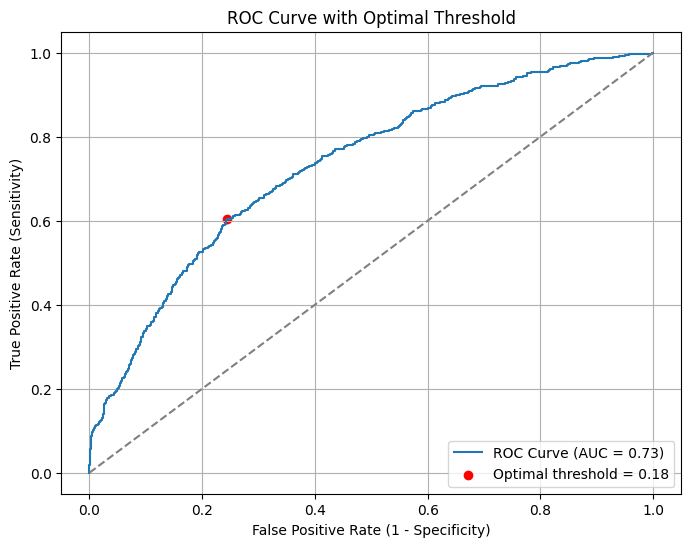

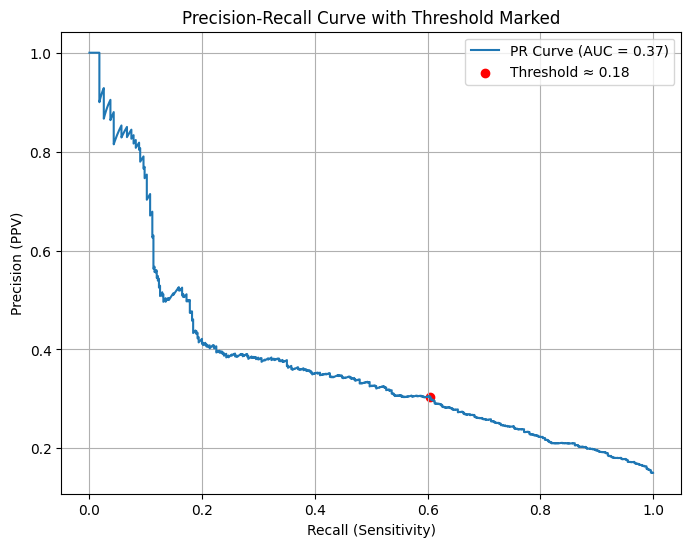

ROC-AUC: 0.7336356326159674
PR-AUC: 0.3715160567971192
Optimal threshold (Youden’s J): 0.17758038203223664


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Predict probabilities on train set
y_train_probs = model.predict_proba(X_train)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_probs)
roc_auc = roc_auc_score(y_train, y_train_probs)

# Youden’s J statistic = sensitivity + specificity - 1 = TPR - FPR
youden_index = tpr - fpr
best_threshold_roc = thresholds[youden_index.argmax()]

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_train, y_train_probs)
pr_auc = auc(recall, precision)

# Find threshold closest to Youden’s J threshold
closest_idx = (np.abs(pr_thresholds - best_threshold_roc)).argmin()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Mark best threshold
plt.scatter(fpr[youden_index.argmax()], tpr[youden_index.argmax()],
            color="red", label=f"Optimal threshold = {best_threshold_roc:.2f}")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")

# Mark best threshold (mapped from ROC Youden’s J)
plt.scatter(recall[closest_idx], precision[closest_idx],
            color="red", label=f"Threshold ≈ {best_threshold_roc:.2f}")

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curve with Threshold Marked")
plt.legend(loc="best")
plt.grid(True)
plt.show()

print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print("Optimal threshold (Youden’s J):", best_threshold_roc)


## Default vs. Optimal threshold (including confusion matrix)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns # Import seaborn

# Predict probabilities on train set
y_train_probs = model.predict_proba(X_train)[:, 1]


# Default 0.5 threshold
default_preds = (y_train_probs >= 0.5).astype(int)
cm_default = confusion_matrix(y_train, default_preds)

# Optimal threshold
optimal_preds = (y_train_probs >= best_threshold_roc).astype(int)
cm_optimal = confusion_matrix(y_train, optimal_preds)

=== Default Threshold (0.5) ===


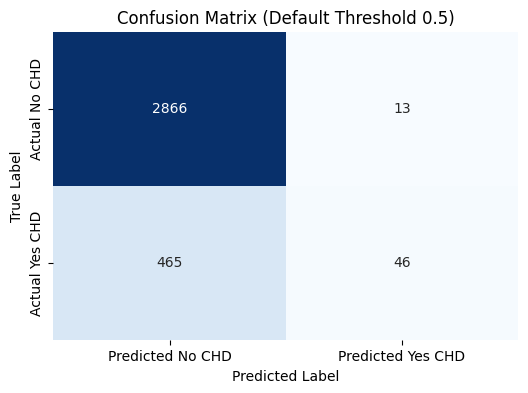

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2879
           1       0.78      0.09      0.16       511

    accuracy                           0.86      3390
   macro avg       0.82      0.54      0.54      3390
weighted avg       0.85      0.86      0.81      3390

=== Optimal Threshold (Youden’s J) ===


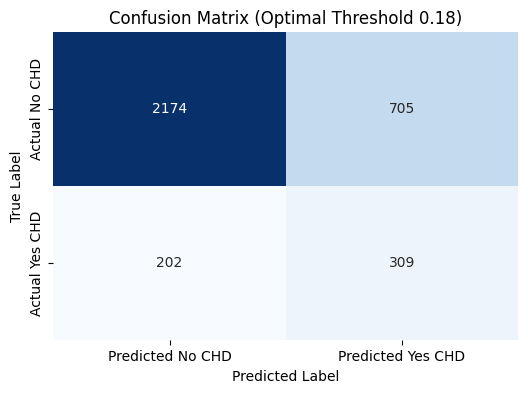

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2879
           1       0.30      0.60      0.41       511

    accuracy                           0.73      3390
   macro avg       0.61      0.68      0.62      3390
weighted avg       0.82      0.73      0.76      3390



In [24]:
print("=== Default Threshold (0.5) ===")
# Plot heatmap for default threshold
plt.figure(figsize=(6, 4))
sns.heatmap(cm_default, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted No CHD', 'Predicted Yes CHD'],
            yticklabels=['Actual No CHD', 'Actual Yes CHD'])
plt.title('Confusion Matrix (Default Threshold 0.5)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, default_preds))

print("=== Optimal Threshold (Youden’s J) ===")
# Plot heatmap for optimal threshold
plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimal, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted No CHD', 'Predicted Yes CHD'],
            yticklabels=['Actual No CHD', 'Actual Yes CHD'])
plt.title(f'Confusion Matrix (Optimal Threshold {best_threshold_roc:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, optimal_preds))

## Test Set Predictions adjusted to Optimal Threshold (~0.18)

In [25]:
# Predict probabilities on test set
test_probs = model.predict_proba(X_test)[:, 1]

# Apply thresholds
# Default 0.5
test_preds_default = (test_probs >= 0.5).astype(int)

# Optimal threshold (from Youden’s J)
test_preds_optimal = (test_probs >= best_threshold_roc).astype(int)

# Create two submission files
submission_default = pd.DataFrame({
    "id": test["id"],
    "CHD_Prediction": test_preds_default,
    "CHD_Probability": test_probs
})

submission_optimal = pd.DataFrame({
    "id": test["id"],
    "CHD_Prediction": test_preds_optimal,
    "CHD_Probability": test_probs
})

# Save them (if you want files for submission/analysis)
submission_default.to_csv("submission_default.csv", index=False)
submission_optimal.to_csv("submission_optimal.csv", index=False)

print("✅ Submissions created with threshold 0.5 and optimal threshold", best_threshold_roc)


✅ Submissions created with threshold 0.5 and optimal threshold 0.17758038203223664


In [26]:
#Count of CHD_Prediction in submission_optimal vs. submission_default df
submission_optimal_counts = submission_optimal["CHD_Prediction"].value_counts()
submission_default_counts = submission_default["CHD_Prediction"].value_counts()

print("\nCount of CHD_Prediction in Submission_default:")
print(submission_default_counts)

print("Count of CHD_Prediction in Submission_optimal:")
print(submission_optimal_counts)


Count of CHD_Prediction in Submission_default:
CHD_Prediction
0    834
1     14
Name: count, dtype: int64
Count of CHD_Prediction in Submission_optimal:
CHD_Prediction
0    617
1    231
Name: count, dtype: int64


## Key Takeaways

### **Model performance**

#### Default threshold (0.5):

* Accuracy: 0.86

* Precision (CHD cases): 0.78

* Recall (CHD cases): 0.09

* F1-score (CHD cases): 0.16

* Interpretation: The model is very conservative — it rarely predicts someone will develop CHD, resulting in almost all positives being missed (false negatives).

#### Optimal threshold (0.18):

* Accuracy: 0.73

* Precision (CHD cases): 0.30

* Recall (CHD cases): 0.60

* F1-score (CHD cases): 0.41

* Interpretation: By lowering the threshold, the model identifies more than half of CHD cases (better sensitivity), but at the cost of more false alarms (false positives).

#### Risk Factors

* Strongest risk-increasing predictors: age, systolic blood pressure, smoking intensity, glucose, and use of BP medication.

* Protective predictors: female sex, higher education, lower diastolic BP, and lower resting heart rate.

* Age is the leading risk-increasing factor; increases CHD risk by about 1.69x. However, this is not a modifiable risk factor


## Recomendations


**1. Threshold Calibration for Clinical Use**

* Use a lower threshold (~0.18) if the goal is early detection of high-risk patients (prioritizing recall). This ensures more at-risk individuals are flagged for further screening or intervention.

* Use the default or higher threshold if the goal is to minimize false positives (e.g., in resource-limited screening settings).

**2. Decision Context Matters**

* In preventive healthcare, missing a true case (false negative) is riskier than a false alarm. Therefore, the 0.18 threshold is recommended for clinical screening tools.

* In contexts where downstream testing is costly or invasive, a higher threshold may be preferable.

**3. Model Development Improvements**

* Address class imbalance via oversampling (SMOTE) or class-weighted logistic regression to reduce bias against the minority (CHD) class.

* Explore non-linear models (Random Forest, XGBoost) to potentially improve ROC-AUC and balance precision-recall tradeoffs.

* Reassess using a confusion matrix to quantify false negatives and false positives under different thresholds.

**4. Clinical Integration**

* Combine this model with traditional risk calculators (e.g., Framingham Risk Score) for validation.

* Provide results to clinicians as risk probabilities rather than binary predictions, leaving final decision-making to medical judgment.